# Tutorial 5: Detección de Anomalías

La detección de anomalías busca identificar instancias cuyas características difieren significativamente del resto de los datos. 
En este tutorial veremos un ejemplo de detección de anomalías a datos de series temporales multivariantes.

Hay varias técnicas basadas en distintos enfoques:
* **Estadísticos.** Por ejemplo, usando modelos paramétricos.
* **Basados en la proximidad.** Por ejemplo: basados en la distancia.
* **Basados en clustering.** Por ejemplo: búsqueda de clusters anómalos. 
* **Basados en la reconstrucción.** Por ejemplo: con un Autoencoder (Red neuronal). 
* **Clasificación de una sola clase.** Por ejemplo, usando Kernels (One Class SVM). 
* **Basados en la teoría de la información.** Usando la ganancia, `Gain(X)`, como medida. 


## Uso de modelos paramétricos 

Este enfoque supone que la mayoría de las instancias de datos se rigen por alguna distribución de probabilidad conocida, por ejemplo, la distribución binomial o gaussiana. Las anomalías pueden detectarse entonces buscando observaciones que no se ajusten a la distribución general de los datos. 

En este ejemplo, nuestro objetivo es detectar cambios anómalos en los precios de cierre diarios de varias acciones. Los datos de entrada *stocks.csv* contienen los precios históricos de cierre de las acciones de 3 grandes empresas (Microsoft, Ford Motor Company y Bank of America). 

In [ ]:
import pandas as pd

stocks = pd.read_csv('http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial9/stocks.csv') 
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'], axis=1)
stocks.shape

(2518, 3)

In [ ]:
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


A continuación calcularemos el porcentaje de cambios en el precio de cierre diario de cada acción:

\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

donde $x_t$ denota el precio de una acción en el día $t$ y $x_{t-1}$ denota el precio en el día anterior, $t-1$.

In [ ]:
import numpy as np

N, d = stocks.shape
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values - stocks.iloc[:N-1,:].values, 
                                   stocks.iloc[:N-1,:].values),
                     columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


Podemos trazar la distribución de las variaciones porcentuales diarias del precio de las acciones. 

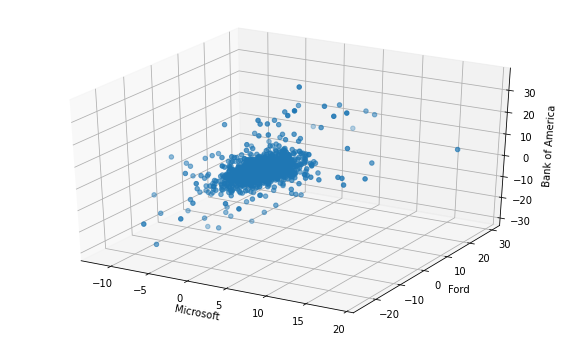

In [ ]:
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6)).gca(projection='3d')
fig.scatter(delta.MSFT, delta.F, delta.BAC)
fig.set_xlabel('Microsoft')
fig.set_ylabel('Ford')
fig.set_zlabel('Bank of America')
plt.show()

Suponiendo que los datos siguen una *distribución gaussiana multivariante*, podemos calcular la media y la matriz de covarianza (Σ) de los datos tridimensionales como sigue:

In [ ]:
meanValue = delta.mean()
print(meanValue)

MSFT    0.045003
F       0.061374
BAC     0.033351
dtype: float64


In [ ]:
covValue = delta.cov()
print(covValue)

          MSFT         F        BAC
MSFT  3.191674  2.136351   2.788870
F     2.136351  8.524944   4.997405
BAC   2.788870  4.997405  13.770761


La densidad de probabilidad varía asimétricamente a medida que nos alejamos del centro en diferentes direcciones. Para tener en cuenta este hecho, necesitamos una medida de distancia que tenga en cuenta la forma de los datos.

Por lo tanto, para determinar los días de negociación anómalos, podemos calcular la distancia de `Mahalanobis` entre el porcentaje de cambio de precios de cada día y el porcentaje medio de cambio de precios.

\begin{equation}
\textrm{Mahalanobis}(x) = (x - \bar{x}) \Sigma^{-1}(x - \bar{x})^T
\end{equation}
donde $x$ es un vector de filas.

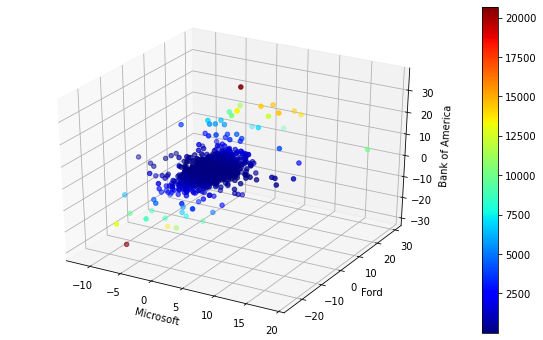

In [ ]:
from numpy.linalg import inv

X = delta.values.copy()
S = covValue.values.copy()

for i in range(3):
    X[:,i] = X[:,i] - meanValue[i]
    
def mahalanobis(row):
    return np.matmul(row,S).dot(row)   
    
anomaly_score = np.apply_along_axis( mahalanobis, axis=1, arr=X)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xs=delta.MSFT, ys=delta.F, zs=delta.BAC, c=anomaly_score, cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

En la figura anterior las 2 mayores anomalías se muestran de color marrón. 

También podemos hacer una visualización interactiva con la librería 'plotly'. 

In [ ]:
import plotly.express as px

fig = px.scatter_3d(delta, x='MSFT', y='F', z='BAC',
                    color=anomaly_score, opacity=0.7)

fig.show()

Podemos examinar las fechas asociadas a las 2 puntuaciones de anomalía más altas de la siguiente manera.

In [ ]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta, anom), axis=1)
result.sort_values('Anomaly score', ascending=False).head(2)

,MSFT,F,BAC,Anomaly score
Date,,,,
4/9/2009,2.501297,7.341772,35.269122,20691.465032
10/7/2008,-6.744279,-20.867209,-26.225949,20471.095209


La anomalía más alta corresponde al día en que los precios de los 3 valores aumentan significativamente, mientras que la segunda anomalía más alta corresponde al día en que los 3 valores sufren una gran caída porcentual en sus precios de cierre. 
Obsérvese que la fuerte caída de las cotizaciones el 7 de octubre de 2008 coincide con el inicio de la crisis financiera mundial https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008.

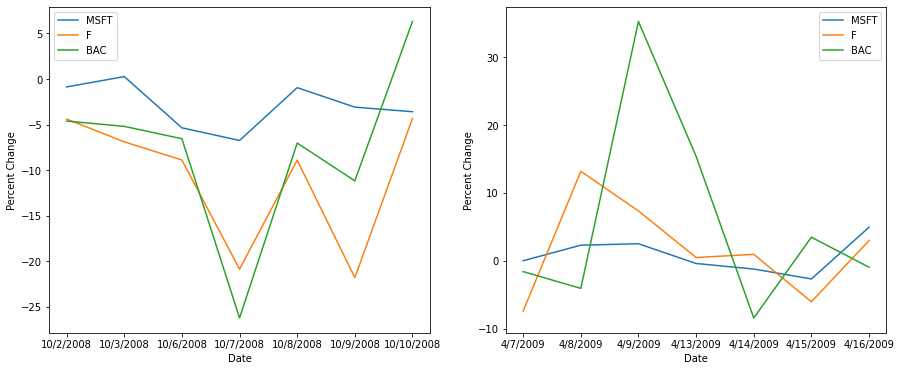

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ts = delta.loc['10/2/2008':'10/10/2008']
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts = delta.loc['4/7/2009':'4/16/2009']
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change');

## Enfoque basado en distancia

Este enfoque no requiere la construcción de un modelo para determinar la puntuación de la anomalía. A continuación, usaremos el enfoque del vecino más cercano. 
Se espera que una instancia normal tenga una pequeña distancia a su k-vecino más cercano, mientras que una anomalía es probable que tenga una gran distancia a su k-vecino más cercano. 

En este ejemplo, usaremos k=4 para identificar los días de negociación anómalos.

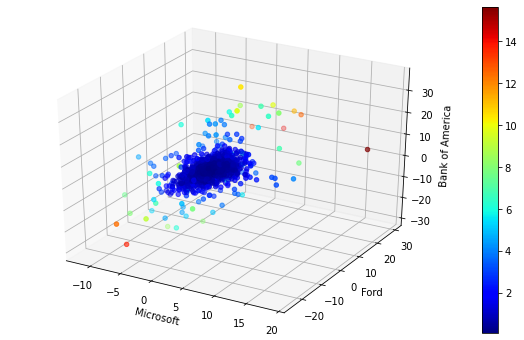

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
import numpy as np

knn = 4
X = delta.values.copy()

nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(X)
distances, indices = nbrs.kneighbors(X)

anomaly_score = distances[:, knn-1]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xs=delta.MSFT, ys=delta.F, zs=delta.BAC, c=anomaly_score, cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

In [ ]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(5, 'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,15.642827
11/26/2008,2.501251,29.518072,4.256757,14.212749
10/7/2008,-6.744279,-20.867209,-26.225949,13.751302
11/28/2008,-1.317721,25.116279,5.314323,13.139586
9/30/2008,6.717317,24.700240,15.702479,12.599739


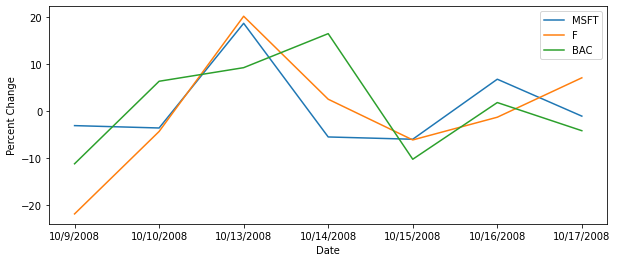

In [ ]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ts = delta.loc['10/9/2008':'10/17/2008']
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change');

## One-class SVM 

Es un algoritmo no supervisado que aprende una función de decisión para la detección de novedades: clasificar los nuevos datos como similares o diferentes al conjunto de entrenamiento.

El modelo realiza la clasificación de las muestras, y retorna +1 o -1. La distancia con signo es negativa para un valor atípico.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(delta)
delta_pca = pca.transform(delta) 

# fit the model
clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma=0.1)
clf.fit(delta_pca)
y_pred = clf.predict(delta_pca)
n_error = y_pred[y_pred==-1].size

In [ ]:
xx, yy = np.meshgrid(np.linspace(-40, 40, 500), np.linspace(-25, 25, 500))

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

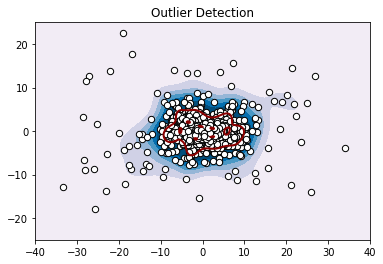

In [ ]:
plt.title("Outlier Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

plt.scatter(delta_pca[:, 0], delta_pca[:, 1], c="white", s=40, edgecolors="k");

In [ ]:
datadelta = delta.copy()
datadelta['y_pred'] = y_pred
datadelta.head()

,MSFT,F,BAC,y_pred
Date,,,,
1/4/2007,-0.167455,2.529960,0.637532,1
1/5/2007,-0.570278,-1.038961,-0.801185,1
1/8/2007,0.978411,1.443570,0.394438,1
1/9/2007,0.100231,0.776197,0.093543,1
1/10/2007,-1.001332,-0.770218,0.149536,1


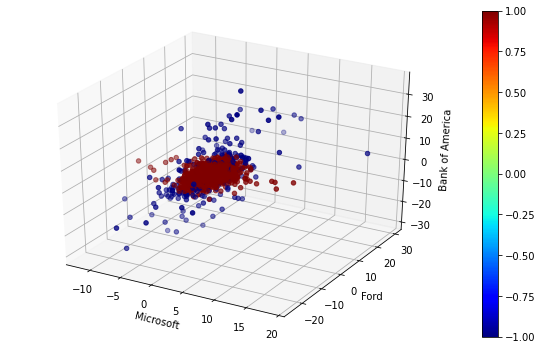

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xs=datadelta.MSFT, ys=datadelta.F, zs=datadelta.BAC, c=datadelta['y_pred'], cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

# Referencias

*  https://www-users.cse.umn.edu/~kumar001/dmbook/index.php
*  http://www.cse.msu.edu/~ptan/dmbook/software/
*  https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html
